In [ ]:
# V. Kavyanjali  email : kavyanjali_v@es.iitr.ac.in
# project on Sentiment_Analysis

In [80]:

#Problem Statement
"""
We have a huge number of comments from YouTube for a latest trailer from a worldwide production house, you as an AI
service provider are supposed to analyse all the comments on that trailer, get the sentiment and the score, and give
a consolidated report for that trailer about how it might perform on the box office.

Here I took the movie "The Social Network"
"""

'\nWe have a huge number of comments from YouTube for a latest trailer from a worldwide production house, you as an AI\nservice provider are supposed to analyse all the comments on that trailer, get the sentiment and the score, and give\na consolidated report for that trailer about how it might perform on the box office.\n\nHere I took the movie "The Social Network"\n'

In [4]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
!pip install transformers

In [6]:
!pip install  vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [7]:
!pip install nltk

In [50]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline

nltk.download('stopwords')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))
nltk.download('vader_lexicon')


classifier = pipeline("sentiment-analysis",model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Device set to use cpu


In [51]:
import pandas as pd
df = pd.read_excel("/content/SocialNetwork Comments.xlsx")

comments= []
comments = df['Comment'].tolist()


In [52]:
def remove_stopwords(raw_comment):
  tokenize_comment = word_tokenize(raw_comment)
  proccessed_comment = [word for word in tokenize_comment if word.lower() not in stop_words]
  return " ".join(proccessed_comment)


In [71]:
def get_comment_sentiment_details(raw_comment):
    """Analyze sentiment of a single comment with word-level details"""
    # Convert to string if not already
    if not isinstance(raw_comment, str):
        raw_comment = str(raw_comment)

    # Skip empty comments
    if not raw_comment.strip():
        return "", "", "NEUTRAL", 0.0

    # Preprocess comment
    processed_comment = remove_stopwords(raw_comment)
    words = processed_comment.split()

    # Get sentiment scores
    sia_scores = sia.polarity_scores(processed_comment)
    compound_score = sia_scores['compound']

    # Get transformer classification
    try:
        transformer_result = classifier(processed_comment)[0]
        comment_sentiment = transformer_result['label'].upper()
        transformer_score = transformer_result['score']
    except Exception as e:
        print(f"Transformer error: {e}")
        comment_sentiment = "NEUTRAL"
        transformer_score = 0.0

    # Determine final sentiment (combining both approaches)
    if abs(compound_score) < 0.05:  # Neutral threshold
        comment_sentiment = "NEUTRAL"
    elif compound_score >= 0.05 and transformer_score > 0.6:
        comment_sentiment = "POSITIVE"
    elif compound_score <= -0.05 and transformer_score > 0.6:
        comment_sentiment = "NEGATIVE"

    # Extract significant words
    positive_words = []
    negative_words = []

    for word in words:
        word_scores = sia.polarity_scores(word)
        if comment_sentiment == "POSITIVE" and word_scores['compound'] > 0.1:
            positive_words.append(word)
        elif comment_sentiment == "NEGATIVE" and word_scores['compound'] < -0.1:
            negative_words.append(word)

    # Calculate final score (weighted approach)
    final_score = compound_score * transformer_score if comment_sentiment != "NEUTRAL" else 0.0

    return (
        " ".join(positive_words),
        " ".join(negative_words),
        comment_sentiment,
        final_score
    )

In [72]:
positive_words = ""
negative_words = ""

pos_values = 0
neg_values = 0
neu_values = 0

pos_values_list = []
neg_values_list = []

avg_pos_value = 0
avg_neg_value = 0

for comment in comments :
  pw,nw,cs,ss = get_comment_sentiment_details(comment)
  positive_words += pw + " "
  negative_words += nw + " "
  if cs == "NEGATIVE":
   neg_values_list.append(ss)
  elif cs == "POSITIVE":
    pos_values_list.append(ss)

  else:
    neu_values+=1

try:
  avg_pos_value = sum(pos_values_list)  / len(pos_values_list)
  avg_neg_value = sum(neg_values_list) / len(neg_values_list)
except ZeroDivisionError:
  if len(pos_values_list) ==0 or len(neg_values_list) == 0:
    avg_pos_value = 0
    avg_neg_value = 0
final_score = (avg_pos_value + avg_neg_value) / (len(pos_values_list) + len(neg_values_list))

In [76]:
final_score

0.0018479829315792323

In [77]:
avg_pos_value

0.6163123026655271

In [79]:
avg_neg_value

-0.3779225044918061

In [73]:
!pip install wordCloud

Positives


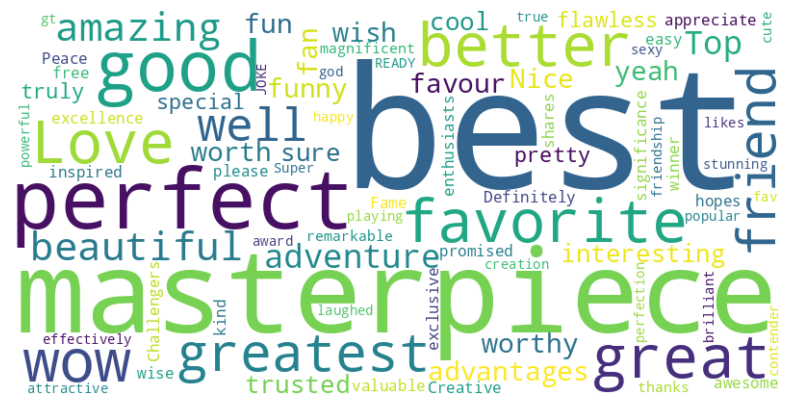

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Positives")
wordcloud_positives = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positives, interpolation="bilinear")
plt.axis('off')
plt.show()

Negatives


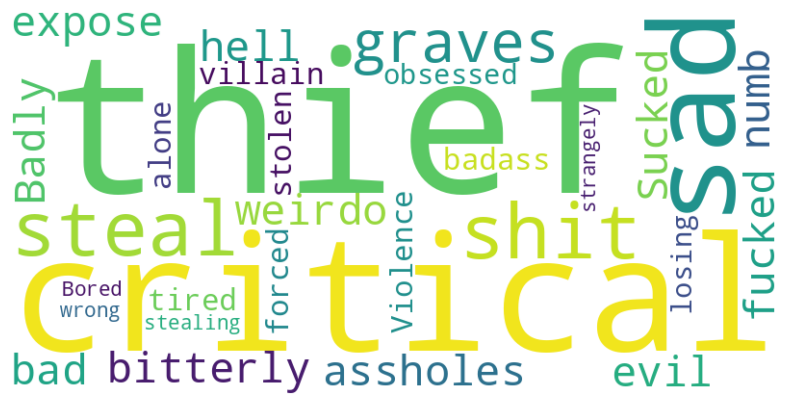

In [75]:
print("Negatives")
wordcloud_negatives = WordCloud(width=800, height=400, background_color="white").generate(negative_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatives, interpolation="bilinear")
plt.axis('off')
plt.show()

In [67]:
positive_words

'Definitely Top favorite adventure like well advantages advantages free well wise yeah like good worth   Nice best best    good    excellence best please    inspired awesome masterpiece    WoW    Perfect Good promised Peace    favours favour hopes appreciate      best  greatest  Greatest   better    amazing best friend  perfect perfect   easy    better fan like wish   worthy                exclusive fun better   funny interesting beautiful cool sure like like Love kind   best friend shares valuable trusted  great  best winner best wish special  better perfect  like     Fame masterpiece   Best  masterpiece  like  significance pretty well  fun worth Best enthusiasts  Creative Challengers perfect top magnificent truly masterpiece     thanks like funny   best Good  remarkable effectively trusted Nice   special happy masterpiece favorite favorite masterpiece  favorite laughed masterpiece god  like good perfect  Best best    like powerful masterpiece likes best JOKE ADVENTURE  best like perf

In [68]:
negative_words

'      thief sad steal thief shit            critical              graves bitterly    assholes expose      weirdo hell     evil fucked         Sucked Badly            numb   bad        villain     critical badass forced                tired               alone    Violence  thief stolen                       obsessed                     losing stealing              strangely wrong                                Bored           '